In [5]:
import pandas as pd

In [6]:
df_bandarban = pd.read_csv('../1980-2024-dataset/Bandarban_historical_weather_1980_2024.csv')

In [7]:
desired_colmn = ['day', 'month', 'year', 'temperature(degree C)', 'humidity', 'dew_point']

df_bandarban = df_bandarban[desired_colmn]
df_bandarban.describe()

,day,month,year,temperature(degree C),humidity,dew_point
count,16437.000000,16437.000000,16437.000000,14764.000000,14764.000000,14764.00000
mean,15.730243,6.522723,2002.000000,26.154403,77.653698,21.57968
std,8.800616,3.448865,12.988187,3.447506,9.532762,4.43595
min,1.000000,1.000000,1980.000000,6.100000,8.200000,-11.90000
25%,8.000000,4.000000,1991.000000,23.900000,72.700000,17.90000
50%,16.000000,7.000000,2002.000000,27.200000,78.900000,23.60000
75%,23.000000,10.000000,2013.000000,28.700000,83.800000,25.10000
max,31.000000,12.000000,2024.000000,34.200000,100.000000,28.80000


In [8]:
with_no_null = df_bandarban.dropna()
print(f"After removing missing values from bandarban, dataset contains {with_no_null.shape[0]} rows and {with_no_null.shape[1]} columns out of {df_bandarban.shape[0]} rows.")
with_no_null.head()

After removing missing values from bandarban, dataset contains 14764 rows and 6 columns out of 16437 rows.


,day,month,year,temperature(degree C),humidity,dew_point
6,7,1,1980,6.1,41.9,-5.9
386,21,1,1981,17.6,80.0,14.0
731,1,1,1982,17.1,82.5,14.1
732,2,1,1982,6.6,70.3,1.1
733,3,1,1982,24.1,8.2,-11.9


In [9]:

# count zeros per column and show as a table
zeros_per_col = (with_no_null == 0).sum()
zeros_df = zeros_per_col.to_frame(name='zero_count')
zeros_df['zero_percentage'] = (zeros_df['zero_count'] / len(with_no_null) * 100).round(2)
zeros_df = zeros_df[zeros_df['zero_count'] > 0].sort_values('zero_count', ascending=False)

print("Number of zeros per column (only columns with > 0 zeros shown):")
display(zeros_df)

# drop rows that contain any 0 or 0.0 and update with_no_null_HI
rows_before = with_no_null.shape[0]
with_no_null_HI = with_no_null[(with_no_null != 0).all(axis=1)]
rows_after = with_no_null_HI.shape[0]
print(f"Dropped {rows_before - rows_after} rows containing zero values. New shape: {with_no_null_HI.shape}")

Number of zeros per column (only columns with > 0 zeros shown):


,zero_count,zero_percentage


Dropped 0 rows containing zero values. New shape: (14764, 6)


# converting to time series

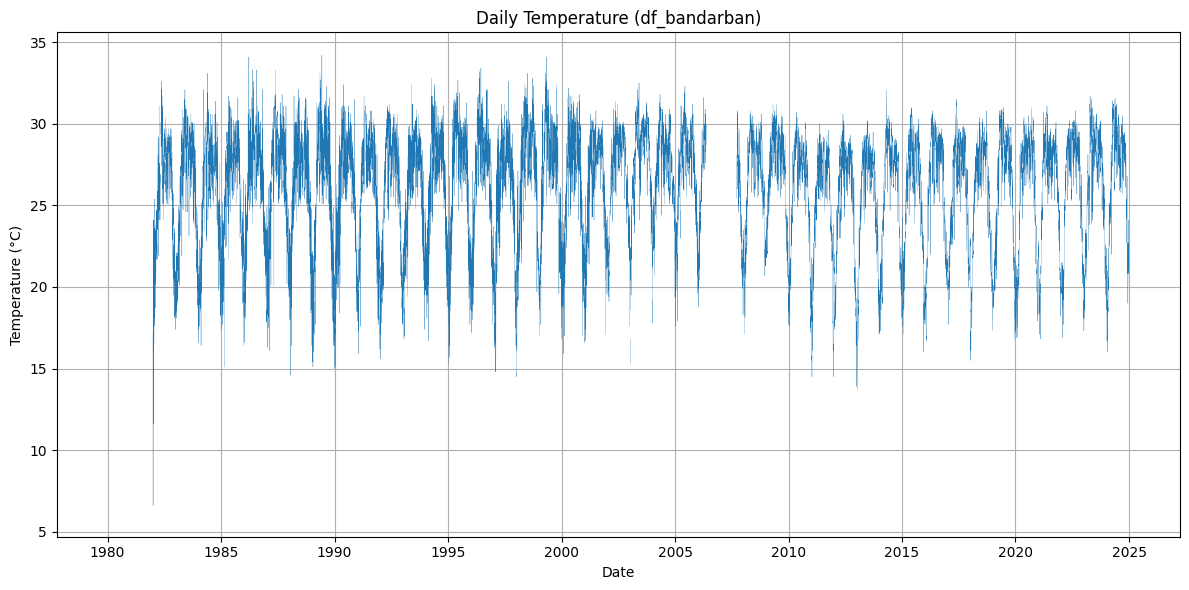

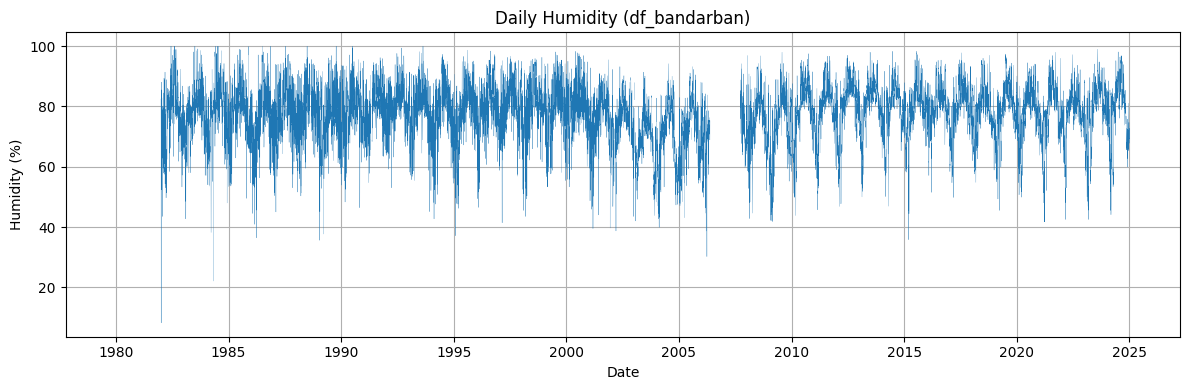

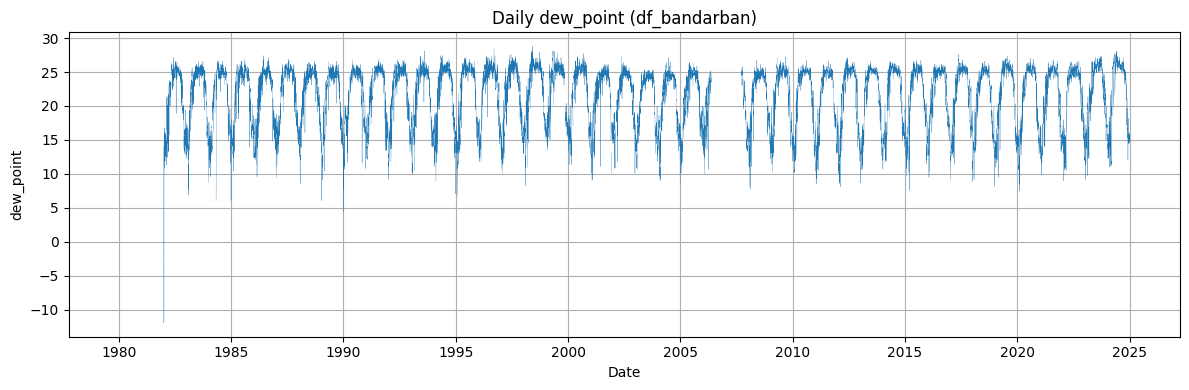

In [10]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (df_bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot daily humidity time series
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Daily Humidity (df_bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# dew point
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['dew_point'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('dew_point')
plt.title('Daily dew_point (df_bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [11]:
with_no_null.head()

,day,month,year,temperature(degree C),humidity,dew_point
6,7,1,1980,6.1,41.9,-5.9
386,21,1,1981,17.6,80.0,14.0
731,1,1,1982,17.1,82.5,14.1
732,2,1,1982,6.6,70.3,1.1
733,3,1,1982,24.1,8.2,-11.9


# features prep with time series 

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


temp_col = 'temperature(degree C)'
hum_col = 'humidity'
dew_col = 'dew_point'

desired_col = ['day', 'month', 'year', temp_col, hum_col, dew_col]

df = df[desired_col].copy()


# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df[temp_col].shift(lag)
    df[f'hum_lag_{lag}'] = df[hum_col].shift(lag)
    df[f'dew_lag_{lag}'] = df[dew_col].shift(lag)
    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'dew_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df[temp_col].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df[hum_col].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df[dew_col].transform(lambda x: x.rolling(window =7).mean())

rolling_cols = ['temp_roll_7', 'hum_roll_7', 'dew_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

FEATURES = ['day', 'month', 'year' ] + fourier_cols + lag_cols + rolling_cols
X = df[FEATURES]
y = pd.DataFrame({
    'temperature': df[temp_col],
    'humidity': df[hum_col],
    'dew_point': df[dew_col]
}).astype(float)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Random Forest with lagging + rolling

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit



targets = y.columns
rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}

for target in targets:
    rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model.fit(X_train, y_train[target])

    y_pred = rf_model.predict(X_test)


    # model evaluation
    mse_rf = mean_squared_error(y_test[target], y_pred)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test[target], y_pred)

    print(f"\nRandom Forest Results for {target}:")
    print(f'MSE: {mse_rf:.4f}')
    print(f'RMSE: {rmse_rf:.4f}')
    print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # Because you have included lags, "Shuffling" can be dangerous. It causes Data Leakage.

    tscv = TimeSeriesSplit(n_splits=5)

    rmse_list_rf = []
    for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]
        
        rf_model_kf = RandomForestRegressor(
            n_estimators= 800 ,
            random_state=42,
            max_depth=22,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            max_features='sqrt'
        )

        rf_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

        mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
        rmse_kf_rf = np.sqrt(mse_kf_rf)
        rmse_list_rf.append(rmse_kf_rf)
        average_rmse_rf = np.mean(rmse_list_rf)
        r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)

    print(f"Average RMSE from K-Fold CV (Random Forest): {average_rmse_rf:.4f}")
    print(f"RMSEs from each fold (Random Forest): {rmse_list_rf}")
    print(f"K fold R²   : {r2_kf_rf:.4f}")
    print(f"K fold MSE  : {mse_kf_rf:.4f}")
    
# Feature importance for Random Forest
    importance = rf_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(feature_importance_df_rf)


# when n = 3 
# temperature: RMSE=1.3715, R²=0.8349, MSE=1.8810
# temperature: CV RMSE=1.4089 ± 0.0241
# temperature: CV R²=0.8401, CV MSE=2.0237
# humidity: RMSE=6.5602, R²=0.5356, MSE=43.0362 
# humidity: CV RMSE=6.6293 ± 0.1343
# humidity: CV R²=0.4863, CV MSE=46.6283

### wtih out shuffling in kfold

# (lagging + rolling) 
# Temp [R2: 0.8920, K fold R² : 0.9404]
# humidity [ R2: 0.7495, K fold R² : 0.7575]

#  only lagging
# Temp [R2: 0.8719, K fold R² : 0.9293]
# humidity [ R2: 0.6247, K fold R² : 0.7236]


Random Forest Results for temperature:
MSE: 0.7569
RMSE: 0.8700
R² Score: 0.9391
Average RMSE from K-Fold CV (Random Forest): 1.0786
RMSEs from each fold (Random Forest): [np.float64(1.340195438775011), np.float64(1.3029785989654676), np.float64(0.97018086579862), np.float64(0.9042368179868704), np.float64(0.8753740603884705)]
K fold R²   : 0.9403
K fold MSE  : 0.7663

Random Forest Feature Importances:
              Feature  Importance
18        temp_roll_7    0.209875
9          temp_lag_1    0.173249
12         temp_lag_2    0.128829
15         temp_lag_3    0.098891
20         dew_roll_7    0.080042
11          dew_lag_1    0.074983
14          dew_lag_2    0.068097
17          dew_lag_3    0.040484
1               month    0.027395
19         hum_roll_7    0.017028
10          hum_lag_1    0.013381
16          hum_lag_3    0.010141
13          hum_lag_2    0.008947
5   day_of_year_sin_2    0.007533
4   day_of_year_cos_1    0.006458
3   day_of_year_sin_1    0.006096
8   day_of_yea

# tolerance testing for the random forest model

In [12]:
# tolerance testing for the random forest model
tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []
for tol in tolerances:
    # temperature
    rf_model_temp = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model_temp.fit(X_train, y_train['temperature'])

    y_pred_temp = rf_model_temp.predict(X_test)
    
    # humidity
    rf_model_hum = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model_hum.fit(X_train, y_train['humidity'])

    y_pred_hum = rf_model_hum.predict(X_test)
    
    # dew point
    rf_model_dew = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model_dew.fit(X_train, y_train['dew_point'])

    y_pred_dew = rf_model_dew.predict(X_test)

    # Apply tolerance
    y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
    y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
    y_pred_dew_tol = np.where(np.abs(y_pred_dew - y_test['dew_point']) <= tol, y_test['dew_point'], y_pred_dew)
    
    # temperature
    mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
    
    # humidity
    mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
    rmse_hum = np.sqrt(mse_hum)
    r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
    
    # dew point
    mse_dew = mean_squared_error(y_test['dew_point'], y_pred_dew_tol)
    rmse_dew = np.sqrt(mse_dew)
    r2_dew = r2_score(y_test['dew_point'], y_pred_dew_tol)


    results.append({
        'tolerance': tol,
        'rmse_temp': rmse_temp,
        'r2_temp': r2_temp,
        'mse_temp': mse_temp,
        'rmse_hum': rmse_hum,
        'r2_hum': r2_hum,
        'mse_hum': mse_hum,
        'rmse_dew': rmse_dew,
        'r2_dew': r2_dew,
        'mse_dew': mse_dew
    })


# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nTolerance Testing Results:")
print(results_df)


Tolerance Testing Results:
   tolerance  rmse_temp   r2_temp  mse_temp  rmse_hum    r2_hum    mse_hum  \
0       0.01   0.869981  0.939066  0.756867  4.402239  0.749453  19.379709   
1       0.05   0.869956  0.939070  0.756824  4.402238  0.749453  19.379700   
2       0.10   0.869816  0.939089  0.756581  4.402230  0.749454  19.379633   
3       0.20   0.868581  0.939262  0.754432  4.402166  0.749461  19.379068   
4       0.30   0.865094  0.939749  0.748388  4.401995  0.749481  19.377560   

   rmse_dew    r2_dew   mse_dew  
0  1.062186  0.946964  1.128240  
1  1.062165  0.946966  1.128196  
2  1.062008  0.946982  1.127861  
3  1.060691  0.947113  1.125066  
4  1.057614  0.947420  1.118548  


In [13]:
# separate rf_model for temp and hum into rf_model_temp and rf_model_hum from rf_model = {}
# If you have a dictionary of models from your training loop:
rf_model_temp = rf_model[0]
rf_model_hum = rf_model[1]
rf_model_dew = rf_model[2]

#  r2_temp_rf = r2_rf[0]    #### problem solve korte hobe  =====   dict e convert 

print(rf_model_temp)
print(rf_model_hum)


DecisionTreeRegressor(max_depth=22, max_features='sqrt',
                      random_state=1608637542)
DecisionTreeRegressor(max_depth=22, max_features='sqrt',
                      random_state=1273642419)


# LSTM-RF hybridization

In [14]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Input
# from sklearn.metrics import mean_squared_error, r2_score
# from keras.optimizers import Adam, SGD

# def create_sequences(x_data, y_data, window_size=5):
#     X_seq, y_seq = [], []
#     for i in range(window_size, len(x_data)):
#         X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
#         y_seq.append(y_data[i])               # The error of the CURRENT day
#     return np.array(X_seq), np.array(y_seq)

# # 1. Chronological Split (No Shuffling!)
# train_size = int(len(df) * 0.8)

# # These keep their column names (Good for RF)
# X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
# rf_model_temp.fit(X_train, y_train['temperature'])
# rf_model_hum.fit(X_train, y_train['humidity'])
# rf_model_dew.fit(X_train, y_train['dew_point'])

# # Get predictions on the training set using the DataFrames
# train_preds_temp = rf_model_temp.predict(X_train)
# train_preds_hum = rf_model_hum.predict(X_train)
# train_preds_dew = rf_model_dew.predict(X_train)

# # Calculate Residuals (Errors)
# res_temp = y_train['temperature'].values - train_preds_temp
# res_hum = y_train['humidity'].values - train_preds_hum
# res_dew = y_train['dew_point'].values - train_preds_dew

# # Combine into a single error target for the LSTM
# train_residuals = np.column_stack([res_temp, res_hum, res_dew])

# # 1. Scale the features for the LSTM
# scaler_x = StandardScaler()
# X_train_scaled = scaler_x.fit_transform(X_train)
# X_test_scaled = scaler_x.transform(X_test)



# # --- NEW SLIDING WINDOW BLOCK ---
# window_size = 5  # You can try 3, 5, or 7

# # Create sequences for training
# X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# # Create sequences for testing
# X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# # Update the LSTM Input Shape
# lstm_model = Sequential([
#     Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
#     LSTM(32, activation='tanh'), 
#     Dense(16, activation='relu'),
#     Dense(3) 
# ])
# # Note: Use train_residuals_seq here instead of train_residuals
# lstm_model.compile(optimizer='adam', loss='mae')
# lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# # --- UPDATED PREDICTION BLOCK ---
# # We skip the first 'window_size' rows of X_test to match the LSTM output
# X_test_aligned = X_test.iloc[window_size:]
# y_test_aligned = y_test.iloc[window_size:]

# # Get RF predictions on the ALIGNED test set
# rf_t_pred = rf_model_temp.predict(X_test_aligned)
# rf_h_pred = rf_model_hum.predict(X_test_aligned)

# # Get LSTM corrections (These will already be aligned because of create_sequences)
# corrections = lstm_model.predict(X_test_lstm)

# # Combine
# final_temp = rf_t_pred + corrections[:, 0]
# final_hum = rf_h_pred + corrections[:, 1]
# final_dew = rf_h_pred + corrections[:,2]

# print(f"Windowed Temp R2: {r2_score(y_test_aligned['temperature'], final_temp):.4f}")
# print(f"Windowed Hum R2: {r2_score(y_test_aligned['humidity'], final_hum):.4f}")
# print(f"Windowed Dew R2: {r2_score(y_test_aligned['dew_point'], final_dew):.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Windowed Temp R2: 0.8359
Windowed Hum R2: 0.2456
Windowed Dew R2: -153.6255


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Input
# from sklearn.metrics import mean_squared_error, r2_score
# from keras.optimizers import Adam, SGD

# # --- STEP 1: Selective Features for LSTM ---
# # We only give the LSTM the most important "weather" features to reduce noise
# lstm_feature_cols = lag_cols + rolling_cols 
# X_train_slim = X_train[lstm_feature_cols]
# X_test_slim = X_test[lstm_feature_cols]

# scaler_slim = StandardScaler()
# X_train_scaled = scaler_slim.fit_transform(X_train_slim)
# X_test_scaled = scaler_slim.transform(X_test_slim)

# # --- STEP 2: Create Sequences ---
# window_size = 7 # Try a full week
# X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
# X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# # --- STEP 3: Optimized LSTM ---
# lstm_model = Sequential([
#     Input(shape=(window_size, X_train_scaled.shape[1])),
#     LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
#     LSTM(50, activation='tanh'),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(2) 
# ])

# # Use a slightly slower learning rate to find the pattern

# lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
# lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# # 1. Align the Test Data (Skip the first 7 days used for the window)
# X_test_aligned = X_test.iloc[window_size:]
# y_test_aligned = y_test.iloc[window_size:]

# # 2. Get the "Base" predictions from your Random Forest
# rf_t_pred = rf_model_temp.predict(X_test_aligned)
# rf_h_pred = rf_model_hum.predict(X_test_aligned)

# # 3. Get the "Corrections" from the LSTM
# # X_test_seq was created during your sequence step
# lstm_corrections = lstm_model.predict(X_test_seq)

# # 4. Combine them: Base + Correction
# final_temp = rf_t_pred + lstm_corrections[:, 0]
# final_hum = rf_h_pred + lstm_corrections[:, 1]

# # 5. Output the New Results
# print("--- HYBRID MODEL PERFORMANCE ---")
# print(f"Final Temp R2: {r2_score(y_test_aligned['temperature'], final_temp):.4f}")
# print(f"Final Hum R2: {r2_score(y_test_aligned['humidity'], final_hum):.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- HYBRID MODEL PERFORMANCE ---
Final Temp R2: 0.8285
Final Hum R2: 0.3161


# XGBoost 

In [15]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor



targets = y.columns
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_rf = {}

for target in targets:
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train[target])

    y_pred = xgb_model.predict(X_test)

    mse_xgb = mean_squared_error(y_test[target], y_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test[target], y_pred)


    print(f"\nXGBoost Results for {target}:")
    print(f'Mean Squared Error: {mse_xgb:.4f}')
    print(f'RMSE: {rmse_xgb:.4f}')
    print(f'R² Score: {r2_xgb:.4f}')


    # K-Fold cross-validation for XGBoost
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_list_xgb = []
    for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        average_rmse_xgb = np.mean(rmse_list_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

    print(f"Average MSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
    print(f"MSEs from each fold (XGBoost): {rmse_list_xgb}")
    print(f"K fold R²   : {r2_kf_xgb:.4f}")
    print(f"K fold MSE  : {mse_kf_xgb:.4f}")
    
# Feature importance for XGBoost
    importance = xgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
    print("\nXGBoost Feature Importances:")
    print(feature_importance_df_xgb)

# (lagging + rolling) xgb
# Temp [R2: 0.8920, K fold R² : 0.9330]
# humidity [ R2: 0.6549, K fold R² : 0.7350]


XGBoost Results for temperature:
Mean Squared Error: 0.8154
RMSE: 0.9030
R² Score: 0.9344
Average MSE from K-Fold CV (XGBoost): 1.1461
MSEs from each fold (XGBoost): [np.float64(1.3967002736887457), np.float64(1.3848803219745067), np.float64(1.0658217693688028), np.float64(0.961220592471552), np.float64(0.921961828865464)]
K fold R²   : 0.9338
K fold MSE  : 0.8500

XGBoost Feature Importances:
              Feature  Importance
18        temp_roll_7    0.834103
9          temp_lag_1    0.057181
15         temp_lag_3    0.009914
11          dew_lag_1    0.009605
1               month    0.008159
19         hum_roll_7    0.006953
10          hum_lag_1    0.006178
6   day_of_year_cos_2    0.005734
12         temp_lag_2    0.005372
20         dew_roll_7    0.005268
16          hum_lag_3    0.005244
13          hum_lag_2    0.005131
17          dew_lag_3    0.005091
5   day_of_year_sin_2    0.005053
8   day_of_year_cos_3    0.004889
4   day_of_year_cos_1    0.004875
7   day_of_year_sin_3   

In [16]:
# tolerance testing using xgboost
tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []

for tol in tolerances:
    xgb_model_temp = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model_temp.fit(X_train, y_train['temperature'])
    y_pred_temp = xgb_model_temp.predict(X_test)

    xgb_model_hum = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model_hum.fit(X_train, y_train['humidity'])
    
    y_pred_hum = xgb_model_hum.predict(X_test)
    # Apply tolerance
    y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
    y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
    mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
    mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
    rmse_hum = np.sqrt(mse_hum)
    r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
    results.append({
        'tolerance': tol,
        'rmse_temp': rmse_temp,
        'r2_temp': r2_temp,
        'mse_temp': mse_temp,
        'rmse_hum': rmse_hum,
        'r2_hum': r2_hum,
        'mse_hum': mse_hum
    })


# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nTolerance Testing Results:")
print(results_df)




Tolerance Testing Results:
   tolerance  rmse_temp   r2_temp  mse_temp  rmse_hum    r2_hum    mse_hum
0       0.01   0.902975  0.934357  0.815364  4.519390  0.735941  20.424886
1       0.05   0.902952  0.934360  0.815323  4.519389  0.735941  20.424876
2       0.10   0.902821  0.934379  0.815086  4.519383  0.735942  20.424820
3       0.20   0.901628  0.934553  0.812933  4.519334  0.735947  20.424381
4       0.30   0.898415  0.935018  0.807150  4.519194  0.735964  20.423117


# Light GBM

In [17]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

targets = y.columns
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}

for target in targets:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=17,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    lgb_model.fit(X_train, y_train[target])

    y_pred = lgb_model.predict(X_test)

    mse_lgb = mean_squared_error(y_test[target], y_pred)
    rmse_lgb = np.sqrt(mse_lgb)
    r2_lgb = r2_score(y_test[target], y_pred)

    print(f"\nLightGBM Results for {target}:")
    print(f'Mean Squared Error: {mse_lgb:.4f}')
    print(f'RMSE: {rmse_lgb:.4f}')
    print(f'R² Score: {r2_lgb:.4f}')

    # --- 6) 5-fold CV R^2 ---
    tscv = TimeSeriesSplit(n_splits=5)
    
    rmse_list_lgb = []
    for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        lgb_model_kf = lgb.LGBMRegressor(
            n_estimators=800,
            learning_rate=0.01,
            max_depth=17,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        average_rmse_lgb = np.mean(rmse_list_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)

    print(f"Average MSE from K-Fold CV (LightGBM): {average_rmse_lgb:.4f}")
    print(f"MSEs from each fold (LightGBM): {rmse_list_lgb}")
    print(f"K fold R²   : {r2_kf_lgb:.4f}")
    print(f"K fold MSE  : {mse_kf_lgb:.4f}")

# Feature importance for LightGBM
    importance = lgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)
    print("\nLightGBM Feature Importances:")
    print(feature_importance_df_lgb)

# (lagging + rolling) lgb
# Temp [R2: 0.8957, K fold R² : 0.9419]
# humidity [ R2: 0.6754, K fold R² : 0.7667]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number of data points in the train set: 10988, number of used features: 21
[LightGBM] [Info] Start training from score 26.100428

LightGBM Results for temperature:
Mean Squared Error: 0.7383
RMSE: 0.8593
R² Score: 0.9406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 2290, number of used features: 21
[LightGBM] [Info] Start training from score 25.841179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [45]:
# tolerance testing using xgboost
tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []

for tol in tolerances:
    lgb_model_temp = lgb.LGBMRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=17,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
        )
    lgb_model_temp.fit(X_train, y_train['temperature'])
    y_pred_temp = lgb_model_temp.predict(X_test)

    lgb_model_kf = lgb.LGBMRegressor(
            n_estimators=800,
            learning_rate=0.01,
            max_depth=17,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        )
    xgb_model_hum.fit(X_train, y_train['humidity'])
    
    y_pred_hum = xgb_model_hum.predict(X_test)
    # Apply tolerance
    y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
    y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
    mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
    mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
    rmse_hum = np.sqrt(mse_hum)
    r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
    results.append({
        'tolerance': tol,
        'rmse_temp': rmse_temp,
        'r2_temp': r2_temp,
        'mse_temp': mse_temp,
        'rmse_hum': rmse_hum,
        'r2_hum': r2_hum,
        'mse_hum': mse_hum
    })


# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nTolerance Testing Results:")
print(results_df)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3411
[LightGBM] [Info] Number of data points in the train set: 11806, number of used features: 17
[LightGBM] [Info] Start training from score 26.191453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3411
[LightGBM] [Info] Number of data points in the train set: 11806, number of used features: 17
[LightGBM] [Info] Start training from score 26.191453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3411
[LightGBM] [Info] Number of data points in the train set: 11806, number of used features: 17
[LightGBM] [Info] Start t

# CATBoost

In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


temp_col = 'temperature(degree C)'
hum_col = 'humidity'
dew_col = 'dew_point'

desired_col = ['day', 'month', 'year', temp_col, hum_col, dew_col]

df = df[desired_col].copy()


# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df[temp_col].shift(lag)
    df[f'hum_lag_{lag}'] = df[hum_col].shift(lag)
    df[f'dew_lag_{lag}'] = df[dew_col].shift(lag)
    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'dew_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df[temp_col].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df[hum_col].transform(lambda x: x.rolling(window=7).mean())
df['dew_roll_7'] = df[dew_col].transform(lambda x: x.rolling(window =7).mean())

rolling_cols = ['temp_roll_7', 'hum_roll_7', 'dew_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

FEATURES = ['day', 'month', 'year' ] + fourier_cols + lag_cols + rolling_cols
X = df[FEATURES]
y = pd.DataFrame({
    'temperature': df[temp_col],
    'humidity': df[hum_col],
    'dew_point': df[dew_col]
}).astype(float)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [57]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split

targets = y.columns
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

for target in targets:
    
    # loss_function='RMSE' is standard for regression
    cat_model = CatBoostRegressor(
        iterations=500, 
        learning_rate=0.1, 
        depth=6, 
        loss_function='RMSE', 
        silent=True
    )
    cat_model.fit(X_train, y_train[target])
    
    y_pred = cat_model.predict(X_test)

    mse_cat = mean_squared_error(y_test[target], y_pred)
    rmse_cat = np.sqrt(mse_cat)
    r2_cat = r2_score(y_test[target], y_pred)
    
    print(f"\nLightGBM Results for {target}:")
    print(f'Mean Squared Error: {mse_cat:.4f}')
    print(f'RMSE: {rmse_cat:.4f}')
    print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_list_cat = []
    
    for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        cat_model_kf = CatBoostRegressor(
            iterations=500, 
            learning_rate=0.1, 
            depth=6, 
            loss_function='RMSE', 
            silent=True
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        average_rmse_cat = np.mean(rmse_list_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

    print(f"Average MSE from K-Fold CV (LightGBM): {average_rmse_cat:.4f}")
    print(f"MSEs from each fold (LightGBM): {rmse_list_cat}")
    print(f"K fold R²   : {r2_kf_cat:.4f}")
    print(f"K fold MSE  : {mse_kf_cat:.4f}")

# Feature importance for LightGBM
    importance = cat_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)
    print("\nLightGBM Feature Importances:")
    print(feature_importance_df_cat)
    
    # results_list.append({
    #     'Target': target.capitalize(),
    #     'Base MSE': round(mse_cat, 4),
    #     'Base RMSE': round(rmse_cat, 4),
    #     'Base R2': round(r2_cat, 4),
    #     '5-Fold Avg R2': round(avg_cv_r2, 4)
    # })

# # Output the matrix
# performance_matrix_cat = pd.DataFrame(results_list)
# print("--- CatBoost Performance Matrix ---")
# print(performance_matrix_cat)


LightGBM Results for temperature:
Mean Squared Error: 0.7323
RMSE: 0.8557
R² Score: 0.9410
Average MSE from K-Fold CV (LightGBM): 1.0716
MSEs from each fold (LightGBM): [np.float64(1.334765555539227), np.float64(1.2991087922083313), np.float64(0.9874540653026197), np.float64(0.8828882413489444), np.float64(0.8535649612276872)]
K fold R²   : 0.9432
K fold MSE  : 0.7286

LightGBM Feature Importances:
              Feature  Importance
18        temp_roll_7   42.038647
9          temp_lag_1   18.102569
12         temp_lag_2    5.078981
19         hum_roll_7    4.216405
15         temp_lag_3    3.687030
10          hum_lag_1    3.456017
11          dew_lag_1    3.153928
17          dew_lag_3    2.451631
1               month    2.089986
2                year    1.930751
16          hum_lag_3    1.750168
20         dew_roll_7    1.720225
13          hum_lag_2    1.678843
14          dew_lag_2    1.408443
0                 day    1.325756
7   day_of_year_sin_3    1.146904
5   day_of_year_sin

# GRU and LSTM

In [16]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam


#  shaping 2D to #D
# 1. Scale the data (Crucial for RNNs)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 2. Reshape to [samples, time_steps, features]
# Here, we treat our engineered features as 1 time step with N features
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [17]:

# GRU model 
def build_gru_model(input_shape, output_shape):
    model = Sequential([
        # First GRU layer
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Second GRU layer
        GRU(32, return_sequences=False),
        Dropout(0.2),
        
        # Output layer (3 neurons for Temp, Hum, Dew Point)
        Dense(output_shape)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

gru_model = build_gru_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]), y_train.shape[1])

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# LSTM 
from keras.layers import LSTM

def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(output_shape)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]), y_train.shape[1])

In [19]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the GRU as an example
history = gru_model.fit(
    X_train_reshaped, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Remember to inverse transform your predictions to get actual Celsius/Humidity values!
predictions_scaled = gru_model.predict(X_test_reshaped)
predictions = scaler_y.inverse_transform(predictions_scaled)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3170 - mae: 0.4073 - val_loss: 0.1304 - val_mae: 0.2557
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2365 - mae: 0.3496 - val_loss: 0.1177 - val_mae: 0.2405
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2275 - mae: 0.3424 - val_loss: 0.1154 - val_mae: 0.2395
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2229 - mae: 0.3392 - val_loss: 0.1149 - val_mae: 0.2364
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2216 - mae: 0.3379 - val_loss: 0.1140 - val_mae: 0.2389
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2183 - mae: 0.3352 - val_loss: 0.1148 - val_mae: 0.2416
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2173 - mae: 0.3340 - val_loss: 0.1108 - val_mae: 0.2353
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2163 - mae: 0.3333 - val_loss: 0.1091 - val_mae: 0.2329
Epoch 9/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

## GRU 

In [25]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prepare your full X and y from the dataframe
X_full = df[FEATURES].values
y_full = df[['temperature(degree C)', 'humidity', 'dew_point']].values

# Choose your model type
MODEL_TYPE = 'GRU' 

# --- PHASE 1: BASE PREDICTION (No CV) ---
# Using the predefined X_train, X_test, y_train, y_test from your workspace
sc_X_base, sc_y_base = StandardScaler(), StandardScaler()
X_train_scaled_base = sc_X_base.fit_transform(X_train)
X_test_scaled_base = sc_X_base.transform(X_test)
y_train_scaled_base = sc_y_base.fit_transform(y_train)

# Reshape for GRU: [samples, timesteps, features]
X_train_reshaped_base = X_train_scaled_base.reshape((X_train_scaled_base.shape[0], 1, X_train_scaled_base.shape[1]))
X_test_reshaped_base = X_test_scaled_base.reshape((X_test_scaled_base.shape[0], 1, X_test_scaled_base.shape[1]))

# Build and train base model
gru_model_base = build_gru_model((1, X_train_scaled_base.shape[1]), y_full.shape[1])
gru_model_base.fit(X_train_reshaped_base, y_train_scaled_base, epochs=50, batch_size=32, verbose=0)

# Predict and inverse scale
y_pred_scaled_base = gru_model_base.predict(X_test_reshaped_base)
y_pred_gru_base = sc_y_base.inverse_transform(y_pred_scaled_base)

# Calculate Individual Metrics for Base
r2_gru_base = r2_score(y_test, y_pred_gru_base, multioutput='raw_values')
mse_gru_base = mean_squared_error(y_test, y_pred_gru_base, multioutput='raw_values')
rmse_gru_base = np.sqrt(mse_gru_base)

print(f"Base {MODEL_TYPE} (no CV) Results:")
print(f"  Temp     - R2: {r2_gru_base[0]:.4f}, RMSE: {rmse_gru_base[0]:.4f}, MSE: {mse_gru_base[0]:.4f}")
print(f"  Humidity - R2: {r2_gru_base[1]:.4f}, RMSE: {rmse_gru_base[1]:.4f}, MSE: {mse_gru_base[1]:.4f}")
print(f"  DewPoint - R2: {r2_gru_base[2]:.4f}, RMSE: {rmse_gru_base[2]:.4f}, MSE: {mse_gru_base[2]:.4f}")
print("-" * 30)


# --- PHASE 2: CROSS-VALIDATION (5-Fold) ---
kf = KFold(n_splits=5, shuffle=False)
all_fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_full), 1):
    # 1. Split Data
    X_train_fold, X_test_fold = X_full[train_idx], X_full[test_idx]
    y_train_fold, y_test_fold = y_full[train_idx], y_full[test_idx]

    # 2. Scale Data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train_fold)
    X_test_scaled = scaler_X.transform(X_test_fold)
    y_train_scaled = scaler_y.fit_transform(y_train_fold)

    # 3. Reshape to 3D
    X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # 4. Build and Fit Model
    input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])
    output_shape = y_full.shape[1]
    
    gru_model_kf = build_gru_model(input_shape, output_shape)
    gru_model_kf.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, verbose=0)

    # 5. Predict and Inverse Scale
    y_pred_scaled = gru_model_kf.predict(X_test_3d)
    y_pred_gru = scaler_y.inverse_transform(y_pred_scaled) 

    # 6. Calculate Metrics
    mse_kf = mean_squared_error(y_test_fold, y_pred_gru)
    rmse_kf = np.sqrt(mse_kf)
    r2_kf = r2_score(y_test_fold, y_pred_gru)

    all_fold_metrics.append([mse_kf, rmse_kf, r2_kf])
    print(f"Fold {fold} | R2: {r2_kf:.4f} | MSE: {mse_kf:.4f} | RMSE: {rmse_kf:.4f}")

# 7. Final Results
avg_metrics = np.mean(all_fold_metrics, axis=0)
print(f"\nFinal Average {MODEL_TYPE} K-Fold Metrics:")
print(f"MSE: {avg_metrics[0]:.4f} | RMSE: {avg_metrics[1]:.4f} | R2: {avg_metrics[2]:.4f}")

# Breakdown of the LAST fold
r2_indiv = r2_score(y_test_fold, y_pred_gru, multioutput='raw_values')
mse_indiv = mean_squared_error(y_test_fold, y_pred_gru, multioutput='raw_values')
rmse_indiv = np.sqrt(mse_indiv)

print(f"\nFold {fold} Breakdown:")
print(f"  Temp     - R2: {r2_indiv[0]:.4f}, RMSE: {rmse_indiv[0]:.4f}, MSE: {mse_indiv[0]:.4f}")
print(f"  Humidity - R2: {r2_indiv[1]:.4f}, RMSE: {rmse_indiv[1]:.4f}, MSE: {mse_indiv[1]:.4f}")
print(f"  DewPoint - R2: {r2_indiv[2]:.4f}, RMSE: {rmse_indiv[2]:.4f}, MSE: {mse_indiv[2]:.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Base GRU (no CV) Results:
  Temp     - R2: 0.9435, RMSE: 0.8376, MSE: 0.7016
  Humidity - R2: 0.7610, RMSE: 4.2993, MSE: 18.4841
  DewPoint - R2: 0.9503, RMSE: 1.0286, MSE: 1.0580
------------------------------


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 1 | R2: 0.7611 | MSE: 15.4036 | RMSE: 3.9247


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 2 | R2: 0.7780 | MSE: 12.5037 | RMSE: 3.5361


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 3 | R2: 0.8261 | MSE: 11.6320 | RMSE: 3.4106


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 4 | R2: 0.8894 | MSE: 6.3708 | RMSE: 2.5240


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 5 | R2: 0.8841 | MSE: 6.7820 | RMSE: 2.6042

Final Average GRU K-Fold Metrics:
MSE: 10.5384 | RMSE: 3.1999 | R2: 0.8277

Fold 5 Breakdown:
  Temp     - R2: 0.9424, RMSE: 0.8455, MSE: 0.7149
  Humidity - R2: 0.7599, RMSE: 4.3091, MSE: 18.5686
  DewPoint - R2: 0.9501, RMSE: 1.0307, MSE: 1.0624


## LSTM

In [24]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prepare your full X and y from the dataframe
X_full = df[FEATURES].values
y_full = df[['temperature(degree C)', 'humidity', 'dew_point']].values

# Choose your model type here: 'GRU' or 'LSTM'
MODEL_TYPE = 'LSTM' 

# base prediciton without CV

#  scaling 
sc_X_base, sc_y_base = StandardScaler(), StandardScaler()
X_train_scaled_base = sc_X_base.fit_transform(X_train)
X_test_scaled_base = sc_X_base.transform(X_test)
y_train_scaled_base = sc_y_base.fit_transform(y_train)

# Reshape for LSTM: [samples, timesteps, features]
X_train_reshaped_base = X_train_scaled_base.reshape((X_train_scaled_base.shape[0], 1, X_train_scaled_base.shape[1]))
X_test_reshaped_base = X_test_scaled_base.reshape((X_test_scaled_base.shape[0], 1, X_test_scaled_base.shape[1]))

# Build and train 
lstm_model_base = build_lstm_model((1, X_train_scaled_base.shape[1]), y_full.shape[1])
lstm_model_base.fit(X_train_reshaped_base, y_train_scaled_base, epochs=50, batch_size=32, verbose=0)

# predict and inverse scale
y_pred_scaled_base = lstm_model_base.predict(X_test_reshaped_base)
y_pred_lstm_base = sc_y_base.inverse_transform(y_pred_scaled_base)

#  performanace matrices 
# 4. Calculate Individual Metrics (multioutput='raw_values')
r2_lstm_base = r2_score(y_test, y_pred_lstm_base, multioutput='raw_values')
mse_lstm_base = mean_squared_error(y_test, y_pred_lstm_base, multioutput='raw_values')
rmse_lstm_base = np.sqrt(mse_lstm_base)

print("Base ANN (no CV) Results:")
print(f"  Temp    - R2: {r2_lstm_base[0]:.4f}, RMSE: {rmse_lstm_base[0]:.4f}, MSE: {mse_lstm_base[0]:.4f}")
print(f"  Humidity- R2: {r2_lstm_base[1]:.4f}, RMSE: {rmse_lstm_base[1]:.4f}, MSE: {mse_lstm_base[1]:.4f}")
print(f"  DewPoint- R2: {r2_lstm_base[2]:.4f}, RMSE: {rmse_lstm_base[2]:.4f}, MSE: {mse_lstm_base[2]:.4f}")

# Initialize 5-Fold
kf = KFold(n_splits=5, shuffle=False)

# Choose your model type here: 'GRU' or 'LSTM'
MODEL_TYPE = 'LSTM' 

all_fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_full), 1):
    # 1. Split Data
    X_train_fold, X_test_fold = X_full[train_idx], X_full[test_idx]
    y_train_fold, y_test_fold = y_full[train_idx], y_full[test_idx]

    # 2. Scale Data (Crucial: Fit on Train, Transform on Test)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train_fold)
    X_test_scaled = scaler_X.transform(X_test_fold)
    y_train_scaled = scaler_y.fit_transform(y_train_fold)
    # y_test_scaled is not needed for final metric calc, we use y_test_fold

    # 3. Reshape to 3D [samples, time_steps, features]
    X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # 4. Build and Fit Model
    input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])
    output_shape = y_full.shape[1]
    
    
    lstm_model_kf = build_lstm_model(input_shape, output_shape)

    lstm_model_kf.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, verbose=0)

    # 5. Predict and Inverse Scale
    y_pred_scaled = lstm_model_kf.predict(X_test_3d)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled) # Convert back to real units

    # 6. Calculate Metrics (Base R2, MSE, RMSE)
    mse_kf_lstm = mean_squared_error(y_test_fold, y_pred_lstm)
    rmse_kf_lstm = np.sqrt(mse_kf_lstm)
    r2_kf_lstm = r2_score(y_test_fold, y_pred_lstm)

    all_fold_metrics.append([mse_kf_lstm, rmse_kf_lstm, r2_kf_lstm])
    print(f"Fold {fold} | R2: {r2_kf_lstm:.4f} | MSE: {mse_kf_lstm:.4f} |RMSE: {rmse_kf_lstm:.4f}")

# 7. Final Results
avg_metrics = np.mean(all_fold_metrics, axis=0)
print(f"\nFinal Average {MODEL_TYPE} Metrics:")
print(f"MSE: {avg_metrics[0]:.4f} | RMSE: {avg_metrics[1]:.4f} | R2: {avg_metrics[2]:.4f}")

print("\n\n")

# Instead of a single value, get an array of 3 values
r2_individual_lstm = r2_score(y_test_fold, y_pred_lstm, multioutput='raw_values')
mse_individual_lstm = mean_squared_error(y_test_fold, y_pred_lstm, multioutput='raw_values')
rmse_individual_lstm = np.sqrt(mse_individual_lstm)

print(f"Fold {fold} Breakdown:")
print(f"  Temp    - R2: {r2_individual_lstm[0]:.4f}, RMSE: {rmse_individual_lstm[0]:.4f}, MSE: {mse_individual_lstm[0]:.4f}")
print(f"  Humidity- R2: {r2_individual_lstm[1]:.4f}, RMSE: {rmse_individual_lstm[1]:.4f}, MSE: {mse_individual_lstm[1]:.4f}")
print(f"  DewPoint- R2: {r2_individual_lstm[2]:.4f}, RMSE: {rmse_individual_lstm[2]:.4f}, MSE: {mse_individual_lstm[2]:.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Base ANN (no CV) Results:
  Temp    - R2: 0.9413, RMSE: 0.8540, MSE: 0.7293
  Humidity- R2: 0.7598, RMSE: 4.3099, MSE: 18.5757
  DewPoint- R2: 0.9485, RMSE: 1.0468, MSE: 1.0959


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 1 | R2: 0.7553 | MSE: 15.4131 |RMSE: 3.9260


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 2 | R2: 0.7759 | MSE: 12.6508 |RMSE: 3.5568


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 3 | R2: 0.8286 | MSE: 11.3745 |RMSE: 3.3726


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 4 | R2: 0.8916 | MSE: 6.2672 |RMSE: 2.5034


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 5 | R2: 0.8870 | MSE: 6.5787 |RMSE: 2.5649

Final Average LSTM Metrics:
MSE: 10.4569 | RMSE: 3.1847 | R2: 0.8277



Fold 5 Breakdown:
  Temp    - R2: 0.9428, RMSE: 0.8429, MSE: 0.7105
  Humidity- R2: 0.7676, RMSE: 4.2396, MSE: 17.9745
  DewPoint- R2: 0.9506, RMSE: 1.0253, MSE: 1.0512


# Artificial Neural Network (ANN)

In [26]:
# Artificial Neural Network (ANN)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def build_ann_model(input_dim, output_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Prepare your full X and y 
X_full = df[FEATURES].values
y_full = df[['temperature(degree C)', 'humidity', 'dew_point']].values
MODEL_TYPE = 'ANN'

# --- PHASE 1: BASE PREDICTION (No CV) ---
# Scaling
sc_X_base, sc_y_base = StandardScaler(), StandardScaler()
X_train_scaled_base = sc_X_base.fit_transform(X_train) # 2D for ANN
X_test_scaled_base = sc_X_base.transform(X_test)
y_train_scaled_base = sc_y_base.fit_transform(y_train)

# Build and train 
ann_model_base = build_ann_model(X_train_scaled_base.shape[1], y_full.shape[1])
ann_model_base.fit(X_train_scaled_base, y_train_scaled_base, epochs=100, batch_size=32, verbose=0)

# Predict and inverse scale
y_pred_scaled_base = ann_model_base.predict(X_test_scaled_base)
y_pred_ann_base = sc_y_base.inverse_transform(y_pred_scaled_base)

# Performance Metrics
r2_ann_base = r2_score(y_test, y_pred_ann_base, multioutput='raw_values')
mse_ann_base = mean_squared_error(y_test, y_pred_ann_base, multioutput='raw_values')
rmse_ann_base = np.sqrt(mse_ann_base)

print(f"Base {MODEL_TYPE} (no CV) Results:")
print(f"  Temp     - R2: {r2_ann_base[0]:.4f}, RMSE: {rmse_ann_base[0]:.4f}, MSE: {mse_ann_base[0]:.4f}")
print(f"  Humidity - R2: {r2_ann_base[1]:.4f}, RMSE: {rmse_ann_base[1]:.4f}, MSE: {mse_ann_base[1]:.4f}")
print(f"  DewPoint - R2: {r2_ann_base[2]:.4f}, RMSE: {rmse_ann_base[2]:.4f}, MSE: {mse_ann_base[2]:.4f}")
print("-" * 30)


# --- PHASE 2: CROSS-VALIDATION (5-Fold) ---
kf = KFold(n_splits=5, shuffle=False)
all_fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_full), 1):
    # 1. Split Data
    X_train_fold, X_test_fold = X_full[train_idx], X_full[test_idx]
    y_train_fold, y_test_fold = y_full[train_idx], y_full[test_idx]

    # 2. Scale Data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train_fold)
    X_test_scaled = scaler_X.transform(X_test_fold)
    y_train_scaled = scaler_y.fit_transform(y_train_fold)

    # 3. Build and Fit Model (ANN remains 2D)
    ann_model_kf = build_ann_model(X_train_scaled.shape[1], y_full.shape[1])
    ann_model_kf.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, verbose=0)

    # 4. Predict and Inverse Scale
    y_pred_scaled = ann_model_kf.predict(X_test_scaled)
    y_pred_ann = scaler_y.inverse_transform(y_pred_scaled)

    # 5. Calculate Metrics
    mse_kf = mean_squared_error(y_test_fold, y_pred_ann)
    rmse_kf = np.sqrt(mse_kf)
    r2_kf = r2_score(y_test_fold, y_pred_ann)

    all_fold_metrics.append([mse_kf, rmse_kf, r2_kf])
    print(f"Fold {fold} | R2: {r2_kf:.4f} | MSE: {mse_kf:.4f} | RMSE: {rmse_kf:.4f}")

# 6. Final Results
avg_metrics = np.mean(all_fold_metrics, axis=0)
print(f"\nFinal Average {MODEL_TYPE} Metrics:")
print(f"MSE: {avg_metrics[0]:.4f} | RMSE: {avg_metrics[1]:.4f} | R2: {avg_metrics[2]:.4f}")

# Breakdown of the LAST fold
r2_indiv = r2_score(y_test_fold, y_pred_ann, multioutput='raw_values')
mse_indiv = mean_squared_error(y_test_fold, y_pred_ann, multioutput='raw_values')
rmse_indiv = np.sqrt(mse_indiv)

print(f"\nFold {fold} Breakdown:")
print(f"  Temp     - R2: {r2_indiv[0]:.4f}, RMSE: {rmse_indiv[0]:.4f}, MSE: {mse_indiv[0]:.4f}")
print(f"  Humidity - R2: {r2_indiv[1]:.4f}, RMSE: {rmse_indiv[1]:.4f}, MSE: {mse_indiv[1]:.4f}")
print(f"  DewPoint - R2: {r2_indiv[2]:.4f}, RMSE: {rmse_indiv[2]:.4f}, MSE: {mse_indiv[2]:.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Base ANN (no CV) Results:
  Temp     - R2: 0.9108, RMSE: 1.0523, MSE: 1.1074
  Humidity - R2: 0.7365, RMSE: 4.5146, MSE: 20.3813
  DewPoint - R2: 0.9139, RMSE: 1.3535, MSE: 1.8320
------------------------------


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 | R2: 0.7416 | MSE: 16.3675 | RMSE: 4.0457


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 | R2: 0.7646 | MSE: 12.8078 | RMSE: 3.5788


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 3 | R2: 0.8051 | MSE: 12.8107 | RMSE: 3.5792


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 4 | R2: 0.8854 | MSE: 6.5961 | RMSE: 2.5683


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5 | R2: 0.8737 | MSE: 7.2650 | RMSE: 2.6954

Final Average ANN Metrics:
MSE: 11.1694 | RMSE: 3.2935 | R2: 0.8141

Fold 5 Breakdown:
  Temp     - R2: 0.9357, RMSE: 0.8940, MSE: 0.7992
  Humidity - R2: 0.7449, RMSE: 4.4420, MSE: 19.7312
  DewPoint - R2: 0.9405, RMSE: 1.1246, MSE: 1.2647


In [14]:
# Artificial Neural Network (ANN)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

def build_ann_model(input_dim, output_dim):
    model = Sequential([
        # Input Layer & First Hidden Layer
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        
        # Second Hidden Layer
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        # Third Hidden Layer
        Dense(16, activation='relu'),
        
        # Output Layer (3 neurons for Temp, Hum, Dew Point)
        # We use 'linear' activation for regression tasks
        Dense(output_dim, activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# Prepare full 2D data
X_ann = df[FEATURES].values
y_ann = df[['temperature(degree C)', 'humidity', 'dew_point']].values


# base prediction
# Base prediction (no cross-validation, train on all except test set)
# Use the same split as X_train, X_test, y_train, y_test

# 1. Scale
sc_X_base, sc_y_base = StandardScaler(), StandardScaler()
X_train_scaled_base = sc_X_base.fit_transform(X_train)
X_test_scaled_base = sc_X_base.transform(X_test)
y_train_scaled_base = sc_y_base.fit_transform(y_train)

# 2. Build & Train
ann_model_base = build_ann_model(X_train_scaled_base.shape[1], y_ann.shape[1])
ann_model_base.fit(X_train_scaled_base, y_train_scaled_base, epochs=100, batch_size=32, verbose=0)

# 3. Predict & Inverse Scale
y_pred_scaled_base = ann_model_base.predict(X_test_scaled_base)
y_pred_ann_base = sc_y_base.inverse_transform(y_pred_scaled_base)

# 4. Calculate Individual Metrics (multioutput='raw_values')
r2_base = r2_score(y_test, y_pred_ann_base, multioutput='raw_values')
mse_base = mean_squared_error(y_test, y_pred_ann_base, multioutput='raw_values')
rmse_base = np.sqrt(mse_base)

print("Base ANN (no CV) Results:")
print(f"  Temp    - R2: {r2_base[0]:.4f}, RMSE: {rmse_base[0]:.4f}, MSE: {mse_base[0]:.4f}")
print(f"  Humidity- R2: {r2_base[1]:.4f}, RMSE: {rmse_base[1]:.4f}, MSE: {mse_base[1]:.4f}")
print(f"  DewPoint- R2: {r2_base[2]:.4f}, RMSE: {rmse_base[2]:.4f}, MSE: {mse_base[2]:.4f}")



kf = KFold(n_splits=5, shuffle=False)
ann_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_ann), 1):
    # 1. Split
    X_train_kf, X_test_kf = X_ann[train_idx], X_ann[test_idx]
    y_train_kf, y_test_kf = y_ann[train_idx], y_ann[test_idx]

    # 2. Scale
    sc_X, sc_y = StandardScaler(), StandardScaler()
    X_train_scaled = sc_X.fit_transform(X_train_kf)
    X_test_scaled = sc_X.transform(X_test_kf)
    y_train_scaled = sc_y.fit_transform(y_train_kf)

    # 3. Build & Train
    ann_model_kf = build_ann_model(X_train_scaled.shape[1], y_ann.shape[1])
    ann_model_kf.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, verbose=0)

    # 4. Predict & Inverse Scale
    y_pred_scaled = ann_model_kf.predict(X_test_scaled)
    y_pred_kf_ann = sc_y.inverse_transform(y_pred_scaled)

    # 5. Calculate Individual Metrics (multioutput='raw_values')
    r2_ind = r2_score(y_test_kf, y_pred_kf_ann, multioutput='raw_values')
    rmse_ind = np.sqrt(mean_squared_error(y_test_kf, y_pred_kf_ann, multioutput='raw_values'))
    
    ann_results.append({'r2': r2_ind, 'rmse': rmse_ind})
    
    print(f"Fold {fold} | Temp R2: {r2_ind[0]:.3f} | Hum R2: {r2_ind[1]:.3f} | Dew R2: {r2_ind[2]:.3f}")

# 6. Aggregate Final Averages
avg_r2 = np.mean([res['r2'] for res in ann_results], axis=0)
avg_rmse = np.mean([res['rmse'] for res in ann_results], axis=0)

# Instead of a single value, get an array of 3 values
r2_individual_ann = r2_score(y_test_kf, y_pred_kf_ann, multioutput='raw_values')
mse_individual_ann = mean_squared_error(y_test_kf, y_pred_kf_ann, multioutput='raw_values')
rmse_individual_ann = np.sqrt(mse_individual_ann)

print(f"Fold {fold} Breakdown:")
print(f"  Temp    - R2: {r2_individual_ann[0]:.4f}, RMSE: {rmse_individual_ann[0]:.4f}, MSE: {mse_individual_ann[0]:.4f}")
print(f"  Humidity- R2: {r2_individual_ann[1]:.4f}, RMSE: {rmse_individual_ann[1]:.4f}, MSE: {mse_individual_ann[1]:.4f}")
print(f"  DewPoint- R2: {r2_individual_ann[2]:.4f}, RMSE: {rmse_individual_ann[2]:.4f}, MSE: {mse_individual_ann[2]:.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Base ANN (no CV) Results:
  Temp    - R2: 0.9272, RMSE: 0.9510, MSE: 0.9045
  Humidity- R2: 0.7403, RMSE: 4.4820, MSE: 20.0881
  DewPoint- R2: 0.9277, RMSE: 1.2398, MSE: 1.5371


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 1 | Temp R2: 0.828 | Hum R2: 0.498 | Dew R2: 0.908


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 | Temp R2: 0.839 | Hum R2: 0.517 | Dew R2: 0.901


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 | Temp R2: 0.837 | Hum R2: 0.698 | Dew R2: 0.895


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 | Temp R2: 0.923 | Hum R2: 0.759 | Dew R2: 0.930


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Fold 5 | Temp R2: 0.925 | Hum R2: 0.748 | Dew R2: 0.930
Fold 5 Breakdown:
  Temp    - R2: 0.9254, RMSE: 0.9624, MSE: 0.9263
  Humidity- R2: 0.7483, RMSE: 4.4122, MSE: 19.4673
  DewPoint- R2: 0.9303, RMSE: 1.2179, MSE: 1.4832


# CNN-LSTM hybrid

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

def build_hybrid_model(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extract local patterns
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Prevent overfitting

        # 2. LSTM Stage: Learn long-term dependencies
        # Note: If passing directly from CNN, you might need to keep sequences
        LSTM(100, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Dense Stage: Final regression
        Dense(50, activation='relu'),
        Dense(1) # Final humidity prediction
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['humidity'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# 2. Define the CNN-LSTM Architecture
def build_hybrid(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Setup Data
window = 30
data_values = df['humidity'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))

print(f"5-Fold CV Average: R2: {np.mean(cv_r2):.4f}, MSE: {np.mean(cv_mse):.4f}, RMSE: {np.mean(cv_rmse):.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Base Results: R2: 0.6297, MSE: 28.6955, RMSE: 5.3568


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5-Fold CV Average: R2: 0.5193, MSE: 40.6256, RMSE: 6.2868


In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

# Targets for your meteorological study
 
targets = [temp_col, hum_col, dew_col]
results_list = []

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

for target in targets:
    # 1. Prepare data for this specific target
    data_values = df[target].values.reshape(-1, 1)
    X, y = create_sequences(data_values, window_size=30)
    
    # 2. Base Performance (Hold-out Test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = build_hybrid((30, 1))
    model.fit(X_train, y_train, epochs=15, verbose=0)
    
    y_pred = model.predict(X_test)
    b_mse, b_rmse, b_r2 = get_metrics(y_test, y_pred)
    
    # 3. 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=False)
    cv_r2_scores = []
    for train_idx, test_idx in kf.split(X):
        # We re-initialize the model for each fold to avoid data leakage
        m = build_hybrid((30, 1))
        m.fit(X[train_idx], y[train_idx], epochs=10, verbose=0)
        p = m.predict(X[test_idx])
        cv_r2_scores.append(r2_score(y[test_idx], p))
    
    avg_cv_r2 = np.mean(cv_r2_scores)
    
    # Store results for the final DataFrame
    results_list.append({
        'Target': target.capitalize(),
        'Base MSE': round(b_mse, 4),
        'Base RMSE': round(b_rmse, 4),
        'Base R2': round(b_r2, 4),
        '5-Fold Avg R2': round(avg_cv_r2, 4)
    })

# Create the Performance Matrix DataFrame
performance_matrix = pd.DataFrame(results_list)
print("--- Final Performance Matrix ---")
print(performance_matrix)

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
--- Final Performance Matrix ---
                  Target  Base MSE  Base RMSE  Base R2  5-Fold Avg R2
0  Temperature(degree c)    1.0450     1.0222   0.9159         0.8464
1               Humidity   27.2307     5.2183   0.6486         0.5197
2              Dew_point    1.7228     1.3126   0.9191         0.9084


# Model performance

In [ ]:
model_performance = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM"],
    "R2": [r2_rf[0], r2_xgb[0], r2_lgb[0]]
    # "KF-R2": [r2_kf_rf, r2_kf_xgb, r2_kf_lgb],
    # "MSE": [mse_rf, mse_xgb, mse_lgb],
    # "KF-MSE": [mse_kf_rf, mse_kf_xgb, mse_kf_lgb]
})

print("\n === Model performance Comparision ===")
print(model_performance.to_string(index=False))

TypeError: 'float' object is not subscriptable